## Identifying Circular Trading in Transactional Data with Multi-stage Clustering



                                                                            Nithin CS16BTECH11005

                                                                            Surya Pramod ES16BTECH11015
                                                                            
                                                                            Krishna Chaitanya CS16BTECH11011                                                                            

### Dataset analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
original_dataset = pd.read_csv('data.csv')
original_dataset.describe()

,Seller,Buyer,Amt
count,708466.000000,708466.000000,7.084660e+05
mean,9495.510809,10689.271725,4.446489e+04
std,8593.744882,9125.190479,9.083406e+04
min,9.000000,1.000000,0.000000e+00
25%,2548.000000,2783.000000,1.006350e+04
50%,6814.000000,7880.000000,2.853200e+04
75%,14907.000000,17104.000000,6.294830e+04
max,32444.000000,32449.000000,5.030950e+07


### Preprocessing

**Drop transactions with value 0**

In [3]:
dataset = original_dataset.drop(original_dataset[original_dataset['Amt'] == 0].index)
dataset.describe()

,Seller,Buyer,Amt
count,707549.000000,707549.000000,7.075490e+05
mean,9501.940555,10696.489437,4.452252e+04
std,8594.180764,9126.080854,9.087879e+04
min,9.000000,1.000000,1.000000e-01
25%,2548.000000,2822.000000,1.010325e+04
50%,6814.000000,7883.000000,2.859330e+04
75%,14907.000000,17139.000000,6.301865e+04
max,32444.000000,32449.000000,5.030950e+07


**Drop self edges**

In [4]:
dataset = dataset.drop(dataset[dataset['Seller'] == dataset['Buyer']].index)
dataset.describe()

,Seller,Buyer,Amt
count,665442.000000,665442.000000,6.654420e+05
mean,9940.664065,11210.800106,4.453210e+04
std,8642.170418,9137.748270,6.633225e+04
min,9.000000,1.000000,1.000000e-01
25%,2782.000000,3182.000000,1.007746e+04
50%,7549.000000,8795.000000,2.878920e+04
75%,15315.000000,17948.000000,6.322500e+04
max,32444.000000,32449.000000,1.898131e+07


### Performing benford analysis on the overall transactions

In [5]:
from math import log10

def benford_analysis(vals):
    # Expected Benford frequencies
    expected_freq = [round(len(vals) * log10(1 + 1/d)) for d in range(1, 10)]

    # Convert to scientific notation and get first digit
    first_digit = lambda x: int(('%e' % x)[0])

    # Get observed first digit frequencies
    observed_freq = [0] * 10
    for val in vals:
        observed_freq[first_digit(val)] += 1
    observed_freq = observed_freq[1:]

    print('Expected frequencies: ', expected_freq)
    print('Observed frequencies: ', observed_freq)
    
    plt.plot(range(1, 10), expected_freq, label='Expected')
    plt.plot(range(1, 10), observed_freq, label='Observed')
    plt.legend(loc='upper right')
    plt.show()
    
    mean_abs_dev = 1/(len(vals)*9) * sum([abs(obv-exp)
                                          for obv, exp in zip(observed_freq, expected_freq)])
    print('Mean absolute deviation: %.6lf' % mean_abs_dev)

Expected frequencies:  [200318, 117179, 83139, 64488, 52691, 44549, 38590, 34039, 30449]
Observed frequencies:  [201751, 80134, 69050, 79204, 67115, 51811, 43240, 37782, 35355]


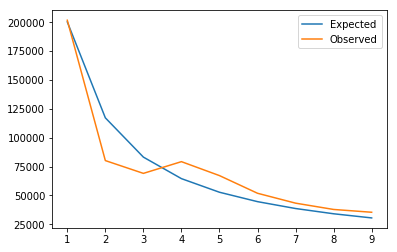

Mean absolute deviation: 0.017076


In [6]:
benford_analysis(dataset['Amt'])

$\text{Mean Absolute Deviation (MAD) is around 0.017 which implies a nonconformity between the expected probability and} \\ \text{the observed probability.}$

### Pruning the transaction graph

- We only consider the nodes (users) which have both incoming and outgoing edges.
- This is because our goal is to identify circular trading and nodes need to have both incoming and outgoing edges to be part of a cycle.

In [7]:
sellers = set(dataset['Seller'])
buyers = set(dataset['Buyer'])
seller_buyer_union = sellers.union(buyers)
seller_buyer_intersection = sellers.intersection(buyers)

print('Sellers:', len(sellers))
print('Buyers:', len(buyers))
print('Sellers Union Buyers:', len(seller_buyer_union))
print('Sellers Intersection Buyers:', len(seller_buyer_intersection))

Sellers: 8354
Buyers: 30400
Sellers Union Buyers: 32369
Sellers Intersection Buyers: 6385


In [8]:
import networkx as nx

In [9]:
G = nx.MultiDiGraph()

for seller, buyer, amt in dataset[['Seller', 'Buyer', 'Amt']].values:
    if (seller in seller_buyer_intersection
            and buyer in seller_buyer_intersection):
        G.add_weighted_edges_from([(int(seller), int(buyer), amt)])

In [10]:
len(G.nodes())

6279

$\text{Even though the total users who act as both buyers and sellers are 6385, we only have 6279 users in our truncated graph, this is because} \\ \text{we only add an edge when both the vertices are buyers and sellers} \\ \text{(Ex: Consider the case a->b->c where b is the only one who is both buying and selling but b won't be added to the updated transaction graph.}$

**Convert graph to stock flow graph**

In [11]:
def stock_flow_graph(G):
    SFG = nx.DiGraph()
    for edge in G.edges(data=True):
        try:
            SFG[edge[0]][edge[1]]['weight'] += edge[-1]['weight']
        
        except KeyError:
            SFG.add_weighted_edges_from(
                [(edge[0], edge[1], edge[-1]['weight'])]
            )

    return SFG

In [12]:
SFG = stock_flow_graph(G)

**Removing edges which satisfy certain conditions (like considering only those weights which fall in a certain range etc)**

In [13]:
def threshold_weights(G, should_consider_edge):
    edges = [
        (u, v, w['weight']) for u, v, w in G.edges(data=True)
        if should_consider_edge(w['weight'])
    ]
    
    X = nx.MultiDiGraph()
    X.add_weighted_edges_from(edges)
    return X

**Function to get the total transactional cost in a cluster**

In [14]:
def total_transactional_cost(G):
    return sum([w['weight'] for _, _, w in G.edges(data=True)])

**Function to display clusters with the given sizes**

In [15]:
def display_clusters(G, clusters, low, high):
    for cluster in clusters:
        if low <= len(cluster) <= high:
            print('Transactional cost:', total_transactional_cost(G.subgraph(cluster)))
            for u, v in set(G.subgraph(cluster).edges()):
                print(u, v)
            print()

## Clustering Stage 1

In [16]:
G_small = nx.MultiDiGraph()

for seller, buyer, amt in dataset[['Seller', 'Buyer', 'Amt']].values[:10000]:
    if (seller in seller_buyer_intersection
            and buyer in seller_buyer_intersection):
        G_small.add_weighted_edges_from([(int(seller), int(buyer), amt)])

### HCS Clustering

In [17]:
def HCS(G):
    """
    Return sets of nodes after running HCS.
    Graph should be connected at first
    """
    
    G = nx.Graph(G)
    components = nx.connected_components(G)

    clusters = []
    if nx.number_connected_components(G) > 1:
        for component in components:
            tmp = G.subgraph(component).copy()
            clusters += HCS(tmp)
            
        return clusters

    edges = nx.minimum_edge_cut(G)
    
    num_nodes = len(G.nodes());
    if (num_nodes < 3) or (len(edges) > num_nodes/2):
        return [list(G.nodes())]
    
    for i in edges:
        G.remove_edge(i[0], i[1])
    
    num_comps = nx.number_connected_components(G)
    comp = nx.connected_components(G)
    
    for i in comp:
        g = G.subgraph(i).copy()
        clusters += HCS(g)
        
    return clusters

### Shared Nearest Neighbor Clustering (using Jarvis-Patrick Algorithm)

In [18]:
def shared_nn_clustering(G, t=3):
    class UnionFind:
        def __init__(self, nodes):
            self.color = {
                node: node
                for node in nodes
            }
            
        def representative(self, i):
            if i != self.color[i]:
                self.color[i] = self.representative(self.color[i])
            return self.color[i]

        def union(self, i, j):
            p_i, p_j = self.representative(i), self.representative(j)
            if p_i != p_j:
                self.color[p_i] = p_j
        
        def is_connected(self, i, j):
            return self.representative(i) == self.representative(j)
    
    G = nx.Graph(G)
    neighbors = {
        n: set(G.neighbors(n))
        for n in G.nodes()
    }
                
    coloring = UnionFind(G.nodes())
    for u in G.nodes():
        for v in neighbors[u]:
            # If u, v share more than t neighbors then given them the same color
            shared_neighbors = neighbors[u].intersection(neighbors[v])
            if len(shared_neighbors) >= t:
                coloring.union(u, v)

    representatives = {
        node: coloring.representative(node)
        for node in G.nodes()
    }

    clusters = []
    for rep in set(representatives.values()):
        cluster = []
        for node, col in representatives.items():
            if col == rep:
                cluster.append(node)

        clusters.append(cluster)                

    return clusters

In [37]:
clusters_snn_only = shared_nn_clustering(G, t=5)

In [38]:
display_clusters(G, clusters_snn_only, 3, 5)

Transactional cost: 10697017.020000003
14834 17365
16471 17365

Transactional cost: 296069.1
13574 3000
19598 17854
19598 3000
19598 13574

Transactional cost: 380040.9
11736 1273
1273 11736
4405 11736

Transactional cost: 1284249.25
11904 13549
13549 11904
18084 11904



### Collusion clustering

In [19]:
def is_km_compatible(G, p, d_size, m):
    return len(G.edges(p)) >= min(m, d_size)

def is_kmh_compatible(G, s1, s2, m, h):
    
    s1_percent = 0
    for i in s1:
        if is_km_compatible(G, i, len(s2), m):
            s1_percent += 1
    s1_percent /= len(s1)
    
    s2_percent = 0
    for i in s2:
        if is_km_compatible(G, i, len(s1), m):
            s2_percent += 1
    s2_percent /= len(s2)
    
    return s1_percent >= h and s2_percent >= h

def collusion_index(G, s):
    i_c = 0
    e_c = 0
    
    for edge in G.edges(data=True):
        if edge[0] in s and edge[1] in s:
            i_c += edge[-1]['weight']
            continue
            
        if edge[0] in s or edge[1] in s:
            e_c += edge[-1]['weight']
    
    if i_c == 0:
        return 0
    
    if e_c == 0:
        return 100
        
    return i_c/e_c

def collusion_level(G, s1, s2):
    s = s1.union(s2)
    return collusion_index(G, s)

# Make sure 1 <= m <= k
def collusion_clustering(G, k, m, h):
    
    G = knn_filter(G, k)
    S = [{i} for i in G.nodes()]
    
    while True:
        B = []
        print('Number of clusters:', len(S))
        
        for i, s_i in enumerate(S):
            for j in range(i+1, len(S)):
                s_j = S[j]
                B.append((s_i, s_j, collusion_level(G, s_i, s_j)))
    
        B.sort(key = lambda x: x[-1], reverse=True)
        
        no_change = True
        
        for i in B:
            if (i[0] not in S) or (i[1] not in S):
                continue
                
            if i[-1] > 0 and is_kmh_compatible(G, i[0], i[1], m, h) :
                no_change = False
                S.remove(i[0])
                S.remove(i[1])
                
                new_set = i[0].union(i[1])
                
                S.append(new_set)
                
        if no_change:
            break
            
    return [list(s) for s in S]

**Functions to get k nearest neighbors, edges and the corresponding subgraph**

In [20]:
def get_k_neighbors(G, n, k):
    if nx.is_directed(G):
        edges = list(G.out_edges(n, data=True))
    else:
        edges = list(G.edges(n, data=True))

    edges.sort(
        key = lambda x: x[-1]['weight'],
        reverse=True
    )
    return [edge[1] for edge in edges[:k]]
    
def get_k_n(G, n, k):
    if nx.is_directed(G):
        edges = list(G.out_edges(n, data=True))
    else:
        edges = list(G.edges(n, data=True))
        
    edges.sort(
        key = lambda x: x[-1]['weight'],
        reverse=True
    )
    return edges[:k]

def knn_filter(G, k):
    
    node_list = list(G.nodes())
    ans_graph = nx.DiGraph()
    
    for i in node_list:
        edges = get_k_n(G, i, k)
        ans_graph.add_weighted_edges_from(
            [(edge[0], edge[1], edge[-1]['weight']) for edge in edges]
        )
        
    return ans_graph

In [21]:
def mutual_nn_clustering(G, k, m, MAX_MNV=1e9):
    
    knn_lists = {
        n: get_k_neighbors(G, n, 1000000)
        for n in G.nodes()
    }
    
    def mnv(cluster_1, cluster_2):
        INF = 1e6
        mnv_bw_pairs = []
        for v1 in cluster_1:
            for v2 in cluster_2:                
                try:
                    mnv_local = (
                        knn_lists[v1].index(v2)
                        + knn_lists[v2].index(v1)
                    )
                except ValueError:
                    mnv_local = INF
                    
                mnv_bw_pairs.append(mnv_local)

        return sum(mnv_bw_pairs)/len(mnv_bw_pairs)
                    
    # Initially every vertex is a singleton cluster
    clusters = [
        [v] for v in G.nodes()
    ]
    while len(clusters) > m:
        print('Clusters: %d' % len(clusters))

        # Find two clusters Ci, Cj s.t mnv(Ci, Cj) is the least possible
        min_mnv = MAX_MNV
        cluster_pair = (None, None)
        for i in range(len(clusters)):
            for j in range(i+1, len(clusters)):
                curr_mnv = mnv(clusters[i], clusters[j])
                if curr_mnv < min_mnv:
                    cluster_pair = (i, j)
                    min_mnv = curr_mnv
                    
        if min_mnv >= MAX_MNV:
            break
                
        # Remove clusters Ci, Cj and add Ci union Cj
        new_cluster = clusters[cluster_pair[0]] + clusters[cluster_pair[1]]
        clusters = [
            cluster
            for i, cluster in enumerate(clusters)
            if i != cluster_pair[0] and i != cluster_pair[1]
        ]
        clusters += [new_cluster]
        
    return clusters

## Clustering stage 2

In [22]:
def get_weighted_graph(G):
    
    weights = []    
    edge_set = {}
    for i in range(len(G.edges())):
        weights.append([0, 0, 0, 0])
    
    for i, edge in enumerate(G.edges()):
        u = edge[0]
        v = edge[1]
        
        suc_set = set(list(G.successors(v)))
        pred_set = set(list(G.predecessors(u)))
        
        common = suc_set.intersection(pred_set)
        
        for j in common:
            cnt = 0
            if G.has_edge(v, u):
                cnt += 1
            if G.has_edge(j, v):
                cnt += 1
            if G.has_edge(u, j):
                cnt += 1
                
            weights[i][cnt] = cnt+1
            
            if u < v:
                edge_set[(u, v)] = max(edge_set.get((u, v), 0), cnt+1)
            else :
                edge_set[(v, u)] = max(edge_set.get((v, u), 0), cnt+1)
            
    ans_graph = nx.Graph()
    
    for (u, v), w in edge_set.items():
        ans_graph.add_weighted_edges_from([(u, v, w)]) 
        
    return ans_graph

**Clusters formed using SNN clustering after converting to 3 cycle weighted graph**

In [23]:
clusters_snn = shared_nn_clustering(get_weighted_graph(G), t=5)

In [24]:
display_clusters(G, clusters_snn, 3, 10)

Transactional cost: 366017113.1000016
5591 2704
4450 5724
7209 5724
2704 5591
5724 4450
4450 7209
5724 5591
2704 1463
4450 1463
1463 5724
5724 1463
5591 1463
5591 4450
7209 5591
2704 5724
1463 5591
1463 2704
5591 5724
2704 7209
7209 1463
7209 2704

Transactional cost: 2315284.24
1940 218
5756 1940
218 1940
1940 5756

Transactional cost: 86636.85
26307 26735
26307 14693
14693 26735
26735 14693
14693 26307



**Clusters formed using Mutual NN clustering after converting to 3 cycle weighted graph**

In [25]:
clusters_mnn = mutual_nn_clustering(get_weighted_graph(G), 3, 1000)

Clusters: 1479
Clusters: 1478
Clusters: 1477
Clusters: 1476
Clusters: 1475
Clusters: 1474
Clusters: 1473
Clusters: 1472
Clusters: 1471
Clusters: 1470
Clusters: 1469
Clusters: 1468
Clusters: 1467
Clusters: 1466
Clusters: 1465
Clusters: 1464
Clusters: 1463
Clusters: 1462
Clusters: 1461
Clusters: 1460
Clusters: 1459
Clusters: 1458
Clusters: 1457
Clusters: 1456
Clusters: 1455
Clusters: 1454
Clusters: 1453
Clusters: 1452
Clusters: 1451
Clusters: 1450
Clusters: 1449
Clusters: 1448
Clusters: 1447
Clusters: 1446
Clusters: 1445
Clusters: 1444
Clusters: 1443
Clusters: 1442
Clusters: 1441
Clusters: 1440
Clusters: 1439
Clusters: 1438
Clusters: 1437
Clusters: 1436
Clusters: 1435
Clusters: 1434
Clusters: 1433
Clusters: 1432
Clusters: 1431
Clusters: 1430
Clusters: 1429
Clusters: 1428
Clusters: 1427
Clusters: 1426
Clusters: 1425
Clusters: 1424
Clusters: 1423
Clusters: 1422
Clusters: 1421
Clusters: 1420
Clusters: 1419
Clusters: 1418
Clusters: 1417
Clusters: 1416
Clusters: 1415
Clusters: 1414
Clusters: 

In [26]:
display_clusters(G, clusters_mnn, 3, 3)

Transactional cost: 2187653.6699999995
1091 7234
1630 1091
7234 1630
1630 7234
1091 1630
7234 1091

Transactional cost: 15385832.920000007
20594 2981
2981 20594
2997 2981
2981 2997
20594 2997
2997 20594

Transactional cost: 42068197.19
10502 3147
3147 5974
10502 5974
5974 10502
5974 3147
3147 10502

Transactional cost: 121373550.32999997
6649 5936
3182 5936
3182 6649
6649 3182
5936 6649
5936 3182

Transactional cost: 25877076.52
3296 4704
4704 3296
3296 1839
4704 1839
1839 4704
1839 3296

Transactional cost: 403181.21
3000 617
1722 3000
3000 1722
1722 617
617 3000

Transactional cost: 1213088.84
2118 3179
14804 3179
3179 14804
14804 2118
3179 2118

Transactional cost: 102083382.18
1822 3916
1823 3916
3916 1823
1822 1823
3916 1822
1823 1822

Transactional cost: 14652654.0
9949 3370
9949 7297
3370 7297
7297 9949
3370 9949

Transactional cost: 503361.13
15349 10255
10255 15349
6472 15349
15349 6472
10255 6472
6472 10255

Transactional cost: 8097674.38
1276 3070
3070 1269
1269 1276
1276 12

**Clusters formed using HCS clustering after applying kNN filter on stock flow graph of the 3 cycle weighted graph**

In [27]:
clusters_hcs = HCS(
    get_weighted_graph(
        knn_filter(
            stock_flow_graph(G),
            k=5
        )
    )
)

In [28]:
display_clusters(G, clusters_hcs, 3, 3)

Transactional cost: 42068197.19
10502 3147
3147 5974
10502 5974
5974 10502
5974 3147
3147 10502

Transactional cost: 21837468.87999999
5485 1339
1339 5485
20607 1339
20607 5485
1339 20607
5485 20607

Transactional cost: 3862816.9999999986
452 7324
7324 16276
16276 452

Transactional cost: 2397255.7
14489 25397
25397 14489
25397 31834
31834 14489

Transactional cost: 22635029.299999993
11880 1500
11880 8084
1500 11880
1500 8084
8084 1500
8084 11880

Transactional cost: 14335102.649999995
5483 2408
26656 5483
2408 26656

Transactional cost: 12416261.56
2475 2472
2472 2475
2472 9248
2475 9248
9248 2475
9248 2472

Transactional cost: 6719125.610000002
21826 93
93 12335
12335 21826

Transactional cost: 4751289.980000002
12450 9126
6459 9126
9126 12450
9126 6459
6459 12450
12450 6459

Transactional cost: 6597013.8599999985
3097 7146
3097 7729
7146 7729
7729 7146
7729 3097

Transactional cost: 53940744.34999998
2586 27224
7865 27224
27224 2586
27224 7865
7865 2586

Transactional cost: 4209389

**Clusters formed using collusion clustering after applying kNN filter on stock flow graph of the 3 cycle weighted graph**

In [29]:
clusters_collusion = collusion_clustering(
    get_weighted_graph(
        knn_filter(
            stock_flow_graph(G),
            k=5
        )
    ),
    k=3,
    m=5,
    h=0.6
)

Number of clusters: 304
Number of clusters: 183
Number of clusters: 95
Number of clusters: 89


In [30]:
display_clusters(G, clusters_collusion, 3, 6)

Transactional cost: 6597013.8599999985
3097 7146
3097 7729
7146 7729
7729 7146
7729 3097

Transactional cost: 53940744.34999998
2586 27224
7865 27224
27224 2586
27224 7865
7865 2586

Transactional cost: 4209389.529999999
13757 7880
18160 7880
18160 13757
7880 13757
7880 18160
13757 18160

Transactional cost: 2170980.58
20190 8513
17866 20190
20190 17866
17866 8513
8513 17866

Transactional cost: 3811167.0899999994
6814 11294
11294 6814
6814 772
11294 772
772 11294

Transactional cost: 2751645.84
4713 1468
1468 3249
3249 4713
3249 1468

Transactional cost: 11836926.519999998
1726 20785
2548 1726
20785 2548

Transactional cost: 66279596.40000002
3980 7246
18518 3980
18518 7246
7246 3980
7246 18518

Transactional cost: 7765776.120000001
24845 20013
15440 20013
24845 15440
20013 15440
15440 24845

Transactional cost: 2602028.9000000004
8351 31182
26294 8351
31182 26294
26294 31182

Transactional cost: 1108983.31
22131 8456
8456 483
22131 483
483 22131

Transactional cost: 1741498.4
10826 4

**Clusters formed using edge-betweenness clustering on 3-cycle weighted graph of the stock flow graph**

In [31]:
from networkx.algorithms.community.centrality import girvan_newman
clusters_centrality_generator = girvan_newman(get_weighted_graph(stock_flow_graph(G)))

In [32]:
clusters_centrality = list(sorted(c) for c in next(clusters_centrality_generator))

In [33]:
display_clusters(G, clusters_centrality, 3, 7)

Transactional cost: 2751645.84
4713 1468
1468 3249
3249 4713
3249 1468

Transactional cost: 2585854.3499999987
356 220
220 356
356 877
877 220
220 877

Transactional cost: 1108983.31
22131 8456
8456 483
22131 483
483 22131

Transactional cost: 102667.0
1288 17833
23527 1288
1288 23527
17833 23527

Transactional cost: 486133.0
10214 15802
12850 15802
12850 10214
15802 12850

Transactional cost: 27472.63
26947 24226
26545 24226
26545 26947
26947 26545
24226 26545

Transactional cost: 3701834.789999999
23545 8810
23545 20497
23545 2372
15380 11416
11416 20497
23545 11416
20497 15380
11416 2372
11416 23545
8810 11416
2372 23545
8810 15380
2372 11416
11416 15380

Transactional cost: 15385832.920000007
20594 2981
2981 20594
2997 2981
2981 2997
20594 2997
2997 20594

Transactional cost: 9475547.209999999
5527 16800
8472 5527
8472 16800
5527 8472
16800 5527

Transactional cost: 174960.0
18838 23835
18838 22316
22316 23835
23835 18838

Transactional cost: 2147118.44
1590 10060
9008 1590
10060 9

**Combining the various clusters obtained**

In [39]:
clusters = (
    clusters_snn
    + clusters_mnn
    + clusters_centrality
    + clusters_collusion
    + clusters_hcs
    + clusters_snn_only
)

In [40]:
def write_clusters_to_file(clusters, filename):
    clusters = [cluster for cluster in clusters if 3 <= len(cluster) <= 10]
    clusters.sort(
        key=lambda cluster: (
            1/len(cluster),
            total_transactional_cost(G.subgraph(cluster))*len(G.subgraph(cluster).edges())
        ),
        reverse=True
    )
    
    with open(filename, 'w') as f_ptr:
        for cluster in clusters:
            f_ptr.write(', '.join(map(str, cluster)) + '\n')
    
    print('Written clustering results to "%s"' % filename)
    print('Each line indicates the set of nodes in that cluster.')

In [41]:
write_clusters_to_file(clusters, 'results.txt')

Written clustering results to "results.txt"
Each line indicates the set of nodes in that cluster.
